In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
PATH='/content/drive/My Drive/corpus.txt'

In [ ]:
with open(PATH,'r') as f:
  corpus=f.read()
f.close()

In [ ]:
import re
reviews=re.split("\%\$\%|\.|\?|\!",corpus)
len(reviews)

5598372

In [ ]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 36.0 MB/s 
     |████████████████████████████████| 240 kB 61.8 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=01dce1ad16f3feb184f67c144c123a951213a989183a04cb223562f826c04a38
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

INFO:stanza:Use device: gpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: sentiment
INFO:stanza:Done loading processors!


In [ ]:
import random
random.seed(42)
train_reviews=random.sample(reviews,150000)

In [ ]:
import pandas as pd
df=pd.DataFrame(train_reviews)
df.rename(columns={0:"review"},inplace=True)

In [ ]:
df

,review
0,These are not worth the trouble
1,The cutter worked perfectly to convert a Micro...
2,It is firm but I'm able to pop it out with fa...
3,"Running, Jumping up and down the earpods stay..."
4,"Being a little nitpicky, the edge isn't round..."
...,...
149995,I was really glad to find a screen protector f...
149996,
149997,
149998,Keep up the good work and make something bett...


In [ ]:
import re
for i in range(len(df)):
  text=str(df.loc[i,"review"])


  #Basic preprocessing like case folding and removing punctuations
  text=text.lower()
  text=re.sub(r"[^a-zA-z]+"," ",text)


  df.loc[i,"review"]=text
  sentence=nlp(text)

  #Labelling using Stanza
  for _,s in enumerate(sentence.sentences):
    df.loc[i,"label"]=s.sentiment
    

In [ ]:
#Removing null values and neutral sentiments
df=df[(df["label"]==0.0) | (df["label"]==2.0)] 

In [ ]:
df

,review,label
0,these are not worth the trouble,0.0
1,the cutter worked perfectly to convert a micro...,2.0
3,running jumping up and down the earpods stay ...,2.0
4,being a little nitpicky the edge isn t rounde...,0.0
5,i am not convinced the part will last very long,0.0
...,...,...
149991,always the best,2.0
149992,after extensive testing and re charging this ...,2.0
149995,i was really glad to find a screen protector f...,2.0
149998,keep up the good work and make something bett...,2.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 6.0 MB/s 
     |████████████████████████████████| 5.5 MB 49.8 MB/s 
     |████████████████████████████████| 1.3 MB 52.1 MB/s 
     |████████████████████████████████| 182 kB 73.2 MB/s 
     |████████████████████████████████| 7.6 MB 66.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=12ece0b6d3fb99ee3aba200f59cf4d22faaa38ee0a91840980d5a504ace7d073
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
#Writing a function to train a Naive Bayes Classifier
def nbayes(data_size):
  df_=df.iloc[:data_size]

  #Splitting into training and testing data
  train,test=train_test_split(df_,test_size=1/3)


  #Using TFIDF to vectorize the sentences
  tfidf=TfidfVectorizer(max_features=900)
  tfidf.fit(train["review"])
  encoded=tfidf.transform(train["review"])


  #Using a Multinomial Naive Bayes Classifier
  mnb=MultinomialNB()
  mnb.fit(encoded,train["label"])


  tfidf.fit(test["review"])
  encoded_test=tfidf.transform(test["review"])

  #Predicting the test values
  y_pred=mnb.predict(encoded_test)
  test["predicted_label"]=y_pred


  #Finding the number of true positives, true negatives, false positives and false negatives to build the confusion matrix
  tp=len(test[(test["label"]==2.0) & (test["predicted_label"]==2.0)])
  fn=len(test[(test["label"]==2.0) & (test["predicted_label"]==0.0)])
  fp=len(test[(test["label"]==0.0) & (test["predicted_label"]==2.0)])
  tn=len(test[(test["label"]==0.0) & (test["predicted_label"]==0.0)])

  #Precision
  p=tp/(tp+fp)

  #Recall
  r=tp/(tp+fn)
  
  #Confusion matrix
  cmat=[[tp,fn],[fp,tn]]

  #F-Score
  fsc=2*p*r/(p+r)

  #Accuracy
  acc=(tp+tn)/(tp+fp+tn+fn)

  
  return acc,p,r,fsc



In [ ]:
#Bulding the classifier on 750 data points
mets=nbayes(750)
print(mets[0])

0.564


The accuracy of the model is very less, which means that the Naive Bayes classifier is unable to capture the sentiments of most of these sentences. One of the primary reasons for this is that the input size is very less. Using 500 sentences to train the classifier is not enough. Another reason is using TF-IDF classifier to formulate the vectors of the sentences. TF-IDF cannot capture the relationship between different words in the sentences. Another reason could be the imbalance in the sentiments of the dataset. There are far more positive labels than negative labels in the training data. Lastly, in most cases, a review as a whole has a sentiment, but every sentence itself does not contain a sentiment, but still Stanza is labelling it with a sentiment which might lead to some overfitting.

We can see that on increasing the number of data points the evaluation metrics do not improve rapidly. This could be due to some mislabeling of the outliers and the inability of the TFIDF to capture word-word relationships.

Using the classifier to predict the sentiment of a sentence generates a probability distribution over the classes. At first, we can use Stanza to collect sentences with neutral sentiments and store them. After training the model, we can use it to predict the sentiments of the neutral statements. Then, we can use the average value of the probability of the classes as an indicator of neutral sentiments. For example, if the output at the last layer of the network lies between 0.4 and 0.6, we can say that any sentence whose predicted value lies between them can be classified as neutral. So, it seems that using Sigmoid as the activation function in the last layer of the Neural Network would be ideal, because if we use Sigmoid, we would get output in the range of 0 to 1, which will help us to classify the sentiments into Positive, Negative and Neutral.

Building an Artificial Neural Network to capture the sentiments of the sentences can drastically improve the accuracy of the model. At first, using Gensim to get Word embeddings instead of TFIDF can severely improve the accuracies of the word vectors. Secondly, using an LSTM with embedding layer could be a good solution. We can also use a Gated Recurrent Unit to build the Neural network. Basically any architecture that can store the important <b>emotive/sentiment</b> words in the memory can be really useful to understand the sentiment of the sentence.

In [ ]:
size=[1500,5000,7500,10000,15000,30000,60000,75000,90000,120000,150000]

In [ ]:
accs,precision,recall,fscore=[],[],[],[]
for i in size:
  acc,p,r,fsc=nbayes(i)
  accs.append(acc)
  precision.append(p)
  recall.append(r)
  fscore.append(fsc)

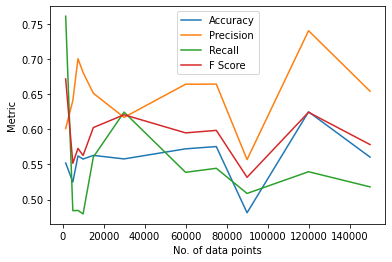

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(size,accs,label="Accuracy")
plt.plot(size,precision,label="Precision")
plt.plot(size,recall,label="Recall")
plt.plot(size,fscore,label="F Score")
plt.xlabel("No. of data points")
plt.ylabel("Metric")
plt.legend()
plt.show()

Performance of classifier: <br>
The accuracy metric improves very little as we increase the number of data points to train our Naive Bayes Classifier. <br>
However, the precision metric improves a lot with increase in number of data points, which means that with increase in number of data points, it learns to reduce the rate of mislabeling the negative sentiments as positive. <br>
But, the recall metric does worse with increase in number of data points, which means that with increase in number of data points, its capability to label only the positive sentences as positive decreases.